## Nitrate 20 m and below

In [2]:
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import pandas as pd
import statsmodels.api as sm
import xarray as xr

In [3]:
foramt = "{:.2}"
myformat = {'bias': foramt, 'rmse': foramt, 'swillmott': foramt, 'slopedev': foramt, 'const': foramt,
                         'systematic': foramt, 'nonsystematic':foramt, 
                    'spread': foramt}

In [4]:
with xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask201702.nc') as mesh:
    deptht = mesh.gdept_1d[0].values

In [5]:
def bias(df, obs, mod):
    diffy = df[mod] - df[obs]
    return diffy.count(), diffy.mean()

In [6]:
def rmse(df, obs, mod):
    return (np.sqrt(((df[mod] - df[obs])**2).mean()))

In [7]:
def swillmott(df, obs, mod):
    meanobs = df[obs].mean()
    return (((df[mod] - df[obs])**2).sum()
            /(( (df[mod] - meanobs).abs() + (df[obs] - meanobs).abs() )**2).sum())

In [8]:
def slope_inter(df, obs, mod):
    X = df[obs]
    y = df[mod]
    X = sm.add_constant(X)

    # Fit and make the predictions by the model
    model = sm.OLS(y, X, missing='drop').fit()
    predictions = model.predict(X)
    
    nonsyst = np.sqrt(((y - predictions)**2).mean())
    systematic = np.sqrt(((predictions - df[obs])**2).mean())
    return model.params[obs], model.params['const'], systematic, nonsyst

In [9]:
def spread(df, obs, mod):
    return 1 - ((df[mod] - df[mod].mean())**2).mean() / ((df[obs] - df[obs].mean())**2).mean() 

In [10]:
def read_pieces(pieces):
    temp1 = pd.read_csv(pieces[0])
    for piece in pieces[1:]:
        nextpiece = pd.read_csv(piece)
        temp1 = pd.concat([temp1, nextpiece], ignore_index=True)
    return temp1

In [11]:
def plot_and_stats(temp1, name, idepth, jdepth):
    fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    vmax = 36
    vmin = 0
    print (deptht[idepth], deptht[jdepth])
    counts, xedges, yedges, color = ax.hist2d(temp1.NO3[(temp1.k >= idepth) & (temp1.k <= jdepth)], 
                                              temp1.mod_nitrate[(temp1.k >= idepth) & (temp1.k <= jdepth)], 
                                           bins=np.arange(vmin, vmax, 0.5), norm=LogNorm());
    fig.colorbar(color)
    number, tbias = bias(temp1[(temp1.k >= idepth) & (temp1.k <= jdepth)], 'NO3', 'mod_nitrate')
    trmse = rmse(temp1[(temp1.k >= idepth) & (temp1.k <= jdepth)], 'NO3', 'mod_nitrate')
    tswillmott = swillmott(temp1[temp1.k >=idepth], 'NO3', 'mod_nitrate')
    m, c, syst, nonsyst = slope_inter(temp1[(temp1.k >= idepth) & (temp1.k <= jdepth)], 'NO3', 'mod_nitrate')
    tspread = spread(temp1[temp1.k >= idepth], 'NO3', 'mod_nitrate')
    ax.plot([vmin, vmax], [vmin, vmax], 'w-');
    xr = np.arange(vmin, vmax, 0.5)
    ax.plot(xr, c + m * xr, 'r-');
    ax.arrow(5, 30, 0, 2-np.abs(tbias)/2, head_width=0.5, head_length=0.2, length_includes_head=True)
    ax.arrow(5, 34, 0, -2+np.abs(tbias)/2, head_width=0.5, head_length=0.2, length_includes_head=True)
    ax.arrow(7, 30, 0, 2-syst/2, head_width=0.5, head_length=0.2, length_includes_head=True)
    ax.arrow(7, 34, 0, -2+syst/2, head_width=0.5, head_length=0.2, length_includes_head=True)
    ax.arrow(9, 29, 0, 3-nonsyst/2, head_width=0.5, head_length=0.2, length_includes_head=True)
    ax.arrow(9, 35, 0, -3+nonsyst/2, head_width=0.5, head_length=0.2, length_includes_head=True);
    Cp2 = {'number': number,
            'bias': tbias,
          'rmse': trmse,
          'swillmott': tswillmott,
          'slopedev': 1-m,
          'const': c,
          'systematic': syst,
          'nonsystematic': nonsyst,
          'spread': tspread}
    ax.text(5-0.6, 26, 'bias', rotation=90)
    ax.text(7-0.6, 22, 'systematic', rotation=90)
    ax.text(9-0.6, 19, 'non-systematic', rotation=90)
    ax.set_title(f'{name}, Nitrate below 20 m');
    dCp2 = pd.DataFrame(data=Cp2, index=[name])
    return dCp2


In [12]:
def plot_and_stats_sal(temp1, name, idepth, jdepth):
    fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    vmax = 35
    vmin = 20
    print (deptht[idepth], deptht[jdepth])
    counts, xedges, yedges, color = ax.hist2d(temp1.SA[(temp1.k >= idepth) & (temp1.k <= jdepth)], 
                                              temp1.mod_vosaline[(temp1.k >= idepth) & (temp1.k <= jdepth)], 
                                           bins=np.arange(vmin, vmax, 0.2), norm=LogNorm());
    fig.colorbar(color)
    number, tbias = bias(temp1[(temp1.k >= idepth) & (temp1.k <= jdepth)], 'SA', 'mod_vosaline')
    trmse = rmse(temp1[(temp1.k >= idepth) & (temp1.k <= jdepth)], 'SA', 'mod_vosaline')
    tswillmott = swillmott(temp1[temp1.k >=idepth], 'SA', 'mod_vosaline')
    m, c, syst, nonsyst = slope_inter(temp1[(temp1.k >= idepth) & (temp1.k <= jdepth)], 'SA', 'mod_vosaline')
    tspread = spread(temp1[temp1.k >= idepth], 'SA', 'mod_vosaline')
    ax.plot([vmin, vmax], [vmin, vmax], 'w-');
    xr = np.arange(vmin, vmax, 0.5)
    ax.plot(xr, c + m * xr, 'r-');
    ax.arrow(13, 31, 0, 1-tbias/2, head_width=0.5, head_length=0.2, length_includes_head=True)
    ax.arrow(13, 33, 0, -1+tbias/2, head_width=0.5, head_length=0.2, length_includes_head=True)
    ax.arrow(14, 31, 0, 1-syst/2, head_width=0.5, head_length=0.2, length_includes_head=True)
    ax.arrow(14, 33, 0, -1+syst/2, head_width=0.5, head_length=0.2, length_includes_head=True)
    ax.arrow(15, 31, 0, 1-nonsyst/2, head_width=0.5, head_length=0.2, length_includes_head=True)
    ax.arrow(15, 33, 0, -1+nonsyst/2, head_width=0.5, head_length=0.2, length_includes_head=True);
    Cp2 = {'number': number,
            'bias': tbias,
          'rmse': trmse,
          'swillmott': tswillmott,
          'slopedev': 1-m,
          'const': c,
          'systematic': syst,
          'nonsystematic': nonsyst,
          'spread': tspread}
    ax.text(13-0.2, 26, 'bias', rotation=90)
    ax.text(14-0.2, 25, 'systematic', rotation=90)
    ax.text(15-0.2, 24, 'non-systematic', rotation=90)
    ax.set_title(f'{name}, Salinity between 15 and 20 m');
    dCp2 = pd.DataFrame(data=Cp2, index=[name])
    return dCp2

In [13]:
pieces = ('/home/sallen/202007/H201812/ObsModel_201812_Bio_20150101-20151231.csv',
         '/home/sallen/202007/H201812/ObsModel_201812_Bio_20160101-20161231.csv',
         '/home/sallen/202007/H201812/ObsModel_201812_Bio_20170101-20171231.csv',
         '/home/sallen/202007/H201812/ObsModel_201812_PSF_20150101-20151231.csv',
  #       '/home/sallen/202007/H201905/ObsModel_201812_PSF_20160101-20161231.csv',
  #       '/home/sallen/202007/H201905/ObsModel_201812_PSF_20170101-20171231.csv',
         '/home/sallen/202007/H201812/ObsModel_H201812_pug_20150101_20151231.csv',
         '/home/sallen/202007/H201812/ObsModel_H201812_pug_20160101_20161231.csv',
         '/home/sallen/202007/H201812/ObsModel_H201812_pug_20170101_20171231.csv',
         '/home/sallen/202007/H201812/ObsModel_H201812_hplc_20150101_20151231.csv',
         '/home/sallen/202007/H201812/ObsModel_H201812_hplc_20160101_20161231.csv',
         '/home/sallen/202007/H201812/ObsModel_H201812_hplc_20170101_20171231.csv')

21.38997868353431 441.4661096800038


/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
H201812,2940,-1.5,3.5,0.13,0.14,2.0,1.7,3.1,-0.16


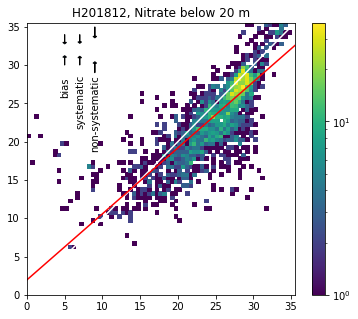

In [14]:
temp1 = read_pieces(pieces)
temp1['NO3'] = temp1.N.fillna(value=temp1.NO23).fillna(value=temp1['Nitrate_plus_Nitrite [umol/L]'])
idepth = 19
jdepth = 39
d201812 = plot_and_stats(temp1, 'H201812', idepth, jdepth)
d201812.style.format(myformat)

In [15]:
pieces = ('/home/sallen/202007/H201905/ObsModel_201905_Bio_20150101-20151231.csv',
         '/home/sallen/202007/H201905/ObsModel_201905_Bio_20160101-20161231.csv',
         '/home/sallen/202007/H201905/ObsModel_201905_Bio_20170101-20171231.csv',
         '/home/sallen/202007/H201905/ObsModel_201905_PSF_20150101-20151231.csv',
  #       '/home/sallen/202007/H201905/ObsModel_201905_PSF_20160101-20161231.csv',
  #       '/home/sallen/202007/H201905/ObsModel_201905_PSF_20170101-20171231.csv',
         '/home/sallen/202007/H201905/ObsModel_H201905_pug_20150101_20151231.csv',
         '/home/sallen/202007/H201905/ObsModel_H201905_pug_20160101_20161231.csv',
         '/home/sallen/202007/H201905/ObsModel_H201905_pug_20170101_20171231.csv',
         '/home/sallen/202007/H201905/ObsModel_H201905_hplc_20150101_20151231.csv',
         '/home/sallen/202007/H201905/ObsModel_H201905_hplc_20160101_20161231.csv',
         '/home/sallen/202007/H201905/ObsModel_H201905_hplc_20170101_20171231.csv')

21.38997868353431 441.4661096800038


/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
H201905,2940,-1.5,3.3,0.14,0.33,6.8,2.2,2.4,0.31


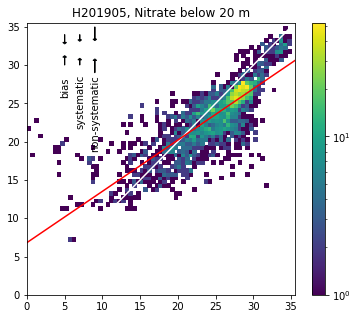

In [16]:
temp1 = read_pieces(pieces)
temp1['NO3'] = temp1.N.fillna(value=temp1.NO23).fillna(value=temp1['Nitrate_plus_Nitrite [umol/L]'])
idepth = 19
jdepth = 39
d201905 = plot_and_stats(temp1, 'H201905', idepth, jdepth)
d201905.style.format(myformat)

In [17]:
pieces = ('/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_Bio_20150101-20151231.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_Bio_20160101-20161231.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_Bio_20170101-20171231.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_PSF_20150101-20150630.csv',
 #        '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_PSF_20160101-20161231.csv',
 #        '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_PSF_20170101-20171231.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_PUG_20150101-20151231.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_PUG_20160101-20161231.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_PUG_20170101-20171231.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_hplc_20150101_20151231.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_hplc_20160101_20161231.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_hplc_20170101_20171231.csv')

21.38997868353431 441.4661096800038


/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
Cp2,2940,-2.2,3.6,0.15,0.24,3.8,2.5,2.6,0.13


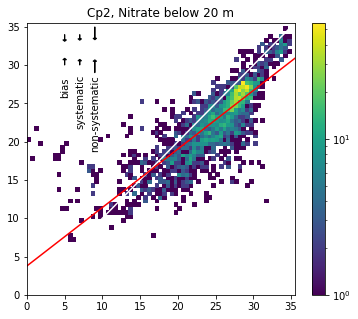

In [18]:
temp1 = read_pieces(pieces)
temp1['NO3'] = temp1.N.fillna(value=temp1.NO23).fillna(value=temp1['Nitrate_plus_Nitrite [umol/L]'])
dCp2 = plot_and_stats(temp1, 'Cp2', idepth, jdepth)
dCp2.style.format(myformat)

In [19]:
pieces = ('/home/sallen/202007/202007D-again/ObsModel_202007D-again_Bio_20150101-20151231.csv',
         '/home/sallen/202007/202007D-again/ObsModel_202007D-again_Bio_20160101-20161231.csv',
         '/home/sallen/202007/202007D-again/ObsModel_202007D-again_Bio_20170101-20171231.csv',
         '/home/sallen/202007/202007D-again/ObsModel_202007D-again_PSF_20150101-20151231.csv',
  #       '/home/sallen/202007/202007D-again/ObsModel_202007D-again_PSF_20160101-20161231.csv',
 #         '/home/sallen/202007/202007D-again/ObsModel_202007D-again_PSF_20170101-20171231.csv',
          '/home/sallen/202007/202007D-again/ObsModel_202007D-again_pug_20150101_20151231.csv',
          '/home/sallen/202007/202007D-again/ObsModel_202007D-again_pug_20160101_20161231.csv',
          '/home/sallen/202007/202007D-again/ObsModel_202007D-again_pug_20170101_20171231.csv',
          '/home/sallen/202007/202007D-again/ObsModel_202007D-again_hplc_20150101_20151231.csv',
          '/home/sallen/202007/202007D-again/ObsModel_202007D-again_hplc_20160101_20161231.csv',
          '/home/sallen/202007/202007D-again/ObsModel_202007D-again_hplc_20170101_20171231.csv'
        )

21.38997868353431 441.4661096800038


/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
Dagain,2940,-1.7,3.3,0.14,0.32,6.5,2.3,2.3,0.31


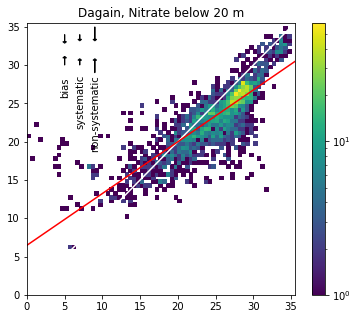

In [20]:
temp1 = read_pieces(pieces)
temp1['NO3'] = temp1.N.fillna(value=temp1.NO23).fillna(value=temp1['Nitrate_plus_Nitrite [umol/L]'])
Dagain = plot_and_stats(temp1, 'Dagain', idepth, jdepth)
Dagain.style.format(myformat)

In [21]:
pieces = ('/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_Bio_20150101-20151231.csv',
         '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_bot_20160101_20161231.csv',
         '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_bot_20170101_20171231.csv',
         '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_PSF_20150101-20151231.csv',
  #       '/home/sallen/202007/202007D-again/ObsModel_202007D-nociliates_psf_20160101-20161231.csv',
 #         '/home/sallen/202007/202007D-again/ObsModel_202007D-nociliates_psf_20170101-20171231.csv',
          '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_pug_20150101_20151231.csv',
          '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_pug_20160101_20161231.csv',
          '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_pug_20170101_20171231.csv',
          '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_hplc_20150101_20151231.csv',
          '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_hplc_20160101_20161231.csv',
          '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_hplc_20170101_20171231.csv'
        )

21.38997868353431 441.4661096800038


/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
D-noCil,2938,-2.2,3.6,0.14,0.25,4.1,2.5,2.6,0.16


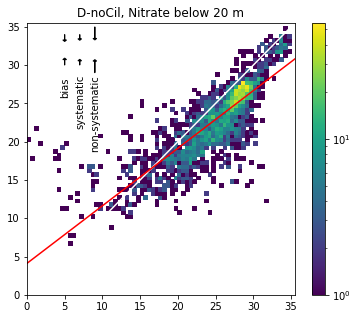

In [22]:
temp1 = read_pieces(pieces)
temp1['NO3'] = temp1.N.fillna(value=temp1.NO23).fillna(value=temp1['Nitrate_plus_Nitrite [umol/L]'])
DnoC = plot_and_stats(temp1, 'D-noCil', idepth, jdepth)
DnoC.style.format(myformat)

In [23]:
pieces = ('/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_Bio_20150101-20151231.csv',
         '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_bot_20160101_20161231.csv',
         '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_bot_20170101_20171231.csv',
         '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_PSF_20150101-20151231.csv',
 #        '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_psf_20160101_20161231.csv',
 #        '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_psf_20170101_20171231.csv',
         '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_pug_20150101_20151231.csv',
         '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_pug_20160101_20161231.csv',
         '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_pug_20170101_20171231.csv',
         '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_hplc_20150101_20151231.csv',
         '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_hplc_20160101_20161231.csv',
         '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_hplc_20170101_20171231.csv')

21.38997868353431 441.4661096800038


/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
D-lowR,2938,-1.6,3.2,0.14,0.33,6.8,2.3,2.3,0.32


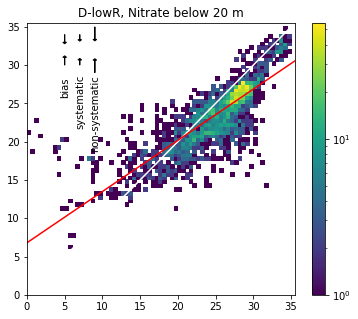

In [24]:
temp1 = read_pieces(pieces)
temp1['NO3'] = temp1.N.fillna(value=temp1.NO23).fillna(value=temp1['Nitrate_plus_Nitrite [umol/L]'])
DlowR = plot_and_stats(temp1, 'D-lowR', idepth, jdepth)
DlowR.style.format(myformat)

In [25]:
pieces = ('/home/sallen/202007/202007C-p3/ObsModel_202007Cp3_bot_20150101_20151231.csv',
          '/home/sallen/202007/202007C-p3/ObsModel_202007Cp3_bot_20160101_20161231.csv',
          '/home/sallen/202007/202007C-p3/ObsModel_202007Cp3_bot_20170101_20171231.csv',
         '/home/sallen/202007/202007C-p3/ObsModel_202007Cp3_psf_20150101_20150331.csv',
          '/home/sallen/202007/202007C-p3/ObsModel_202007Cp3_psf_20150401_20150630.csv',
          '/home/sallen/202007/202007C-p3/ObsModel_202007Cp3_PSF_20150701-20151231.csv',
#          '/home/sallen/202007/202007C-p3/ObsModel_202007Cp3_psf_20160101_20161231.csv',
#          '/home/sallen/202007/202007C-p3/ObsModel_202007Cp3_psf_20170101_20171231.csv',
         '/home/sallen/202007/202007C-p3/ObsModel_202007Cp3_pug_20150101_20150331.csv',
          '/home/sallen/202007/202007C-p3/ObsModel_202007Cp3_pug_20150401_20150630.csv',
          '/home/sallen/202007/202007C-p3/ObsModel_202007Cp3_PUG_20150701-20151231.csv',
          '/home/sallen/202007/202007C-p3/ObsModel_202007Cp3_pug_20160101_20161231.csv',
          '/home/sallen/202007/202007C-p3/ObsModel_202007Cp3_pug_20170101_20171231.csv',
         '/home/sallen/202007/202007C-p3/ObsModel_202007Cp3_hplc_20150101_20151231.csv',
         '/home/sallen/202007/202007C-p3/ObsModel_202007Cp3_hplc_20160101_20161231.csv',
         '/home/sallen/202007/202007C-p3/ObsModel_202007Cp3_hplc_20170101_20171231.csv')

In [26]:
for i in range(len(pieces)):
    nextpiece = pd.read_csv(pieces[i])
    try:
        print (pieces[i], nextpiece.mod_nitrate[0])
    except:
        print (pieces[i], 'not found')

/home/sallen/202007/202007C-p3/ObsModel_202007Cp3_bot_20150101_20151231.csv 21.476430892944336
/home/sallen/202007/202007C-p3/ObsModel_202007Cp3_bot_20160101_20161231.csv 18.22796058654785
/home/sallen/202007/202007C-p3/ObsModel_202007Cp3_bot_20170101_20171231.csv 11.329421043395996
/home/sallen/202007/202007C-p3/ObsModel_202007Cp3_psf_20150101_20150331.csv 22.89947891235352
/home/sallen/202007/202007C-p3/ObsModel_202007Cp3_psf_20150401_20150630.csv 7.24182653427124
/home/sallen/202007/202007C-p3/ObsModel_202007Cp3_PSF_20150701-20151231.csv 13.096561431884766
/home/sallen/202007/202007C-p3/ObsModel_202007Cp3_pug_20150101_20150331.csv 21.429197311401367
/home/sallen/202007/202007C-p3/ObsModel_202007Cp3_pug_20150401_20150630.csv 2.5228495597839355
/home/sallen/202007/202007C-p3/ObsModel_202007Cp3_PUG_20150701-20151231.csv 1.8491103649139404
/home/sallen/202007/202007C-p3/ObsModel_202007Cp3_pug_20160101_20161231.csv 17.966466903686523
/home/sallen/202007/202007C-p3/ObsModel_202007Cp3_pug_

21.38997868353431 441.4661096800038


/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
Cp3,2936,-2.3,3.7,0.15,0.23,3.7,2.5,2.6,0.12


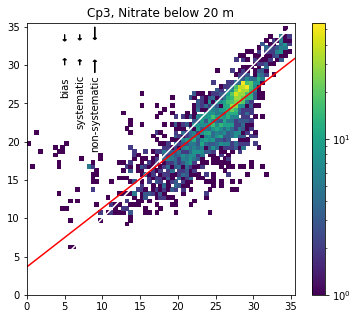

In [27]:
temp1 = read_pieces(pieces)
temp1['NO3'] = temp1.N.fillna(value=temp1.NO23).fillna(value=temp1['Nitrate_plus_Nitrite [umol/L]'])
modCp3 = plot_and_stats(temp1, 'Cp3', idepth, jdepth)
modCp3.style.format(myformat)

In [28]:
pieces = ('/home/sallen/202007/202007F/ObsModel_202007F_bot_20150101_20151231.csv',
          '/home/sallen/202007/202007F/ObsModel_202007F_bot_20160101_20161231.csv',
          '/home/sallen/202007/202007F/ObsModel_202007F_bot_20170101_20171231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_psf_20150101_20151231.csv',
#          '/home/sallen/202007/202007F/ObsModel_202007F_psf_20160101_20161231.csv',
#          '/home/sallen/202007/202007F/ObsModel_202007F_psf_20170101_20171231.csv',
        '/home/sallen/202007/202007F/ObsModel_202007F_pug_20150101_20151231.csv',
          '/home/sallen/202007/202007F/ObsModel_202007F_pug_20160101_20161231.csv',
          '/home/sallen/202007/202007F/ObsModel_202007F_pug_20170101_20171231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_hplc_20150101_20151231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_hplc_20160101_20161231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_hplc_20170101_20171231.csv')

21.38997868353431 441.4661096800038


/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
F,2938,-1.8,3.4,0.15,0.32,6.3,2.4,2.4,0.29


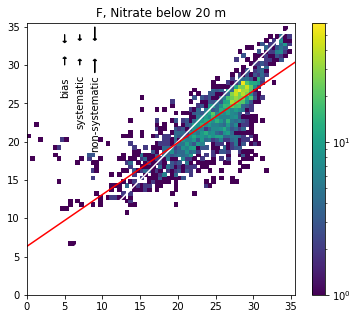

In [29]:
temp1 = read_pieces(pieces)
temp1['NO3'] = temp1.N.fillna(value=temp1.NO23).fillna(value=temp1['Nitrate_plus_Nitrite [umol/L]'])
modF = plot_and_stats(temp1, 'F', idepth, jdepth)
modF.style.format(myformat)

In [30]:
def highlight_max_min(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = abs(s) == abs(s).max()
    is_min = abs(s) == abs(s).min()
    color = []
    for v, v2 in zip(is_max, is_min):
        if v:
            color.append('red')
        elif v2:
            color.append('darkgreen')
        else:
            color.append('black')
    return ['color: %s' % color[i] for i in range(len(is_max))]

In [33]:
alltogether = pd.concat([d201812, d201905, dCp2, modCp3, Dagain, DnoC, DlowR, modF], axis=0)
foramt = "{:.2}"
alltogether.style.format(myformat).apply(highlight_max_min)

,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
H201812,2940,-1.5,3.5,0.13,0.14,2.0,1.7,3.1,-0.16
H201905,2940,-1.5,3.3,0.14,0.33,6.8,2.2,2.4,0.31
Cp2,2940,-2.2,3.6,0.15,0.24,3.8,2.5,2.6,0.13
Cp3,2936,-2.3,3.7,0.15,0.23,3.7,2.5,2.6,0.12
Dagain,2940,-1.7,3.3,0.14,0.32,6.5,2.3,2.3,0.31
D-noCil,2938,-2.2,3.6,0.14,0.25,4.1,2.5,2.6,0.16
D-lowR,2938,-1.6,3.2,0.14,0.33,6.8,2.3,2.3,0.32
F,2938,-1.8,3.4,0.15,0.32,6.3,2.4,2.4,0.29


**Conclusion** 201812 has the best deep nitrate.  Fuzz with low model values and obs between 25 and 30 is Puget.

## Question 1: Is the inclusion of Puget Sound why the nitrate is so underpredicted?

In [28]:
pieces = ('/home/sallen/202007/202007F/ObsModel_202007F_bot_20150101_20151231.csv',
          '/home/sallen/202007/202007F/ObsModel_202007F_bot_20160101_20161231.csv',
          '/home/sallen/202007/202007F/ObsModel_202007F_bot_20170101_20171231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_psf_20150101_20151231.csv',
#          '/home/sallen/202007/202007F/ObsModel_202007F_psf_20160101_20161231.csv',
#          '/home/sallen/202007/202007F/ObsModel_202007F_psf_20170101_20171231.csv',
#         '/home/sallen/202007/202007F/ObsModel_202007F_pug_20150101_20151231.csv',
#          '/home/sallen/202007/202007F/ObsModel_202007F_pug_20160101_20161231.csv',
#          '/home/sallen/202007/202007F/ObsModel_202007F_pug_20170101_20171231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_hplc_20150101_20151231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_hplc_20160101_20161231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_hplc_20170101_20171231.csv')

21.38997868353431 441.4661096800038


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
F,2429,-1.6,2.6,0.11,0.25,5.0,1.9,1.8,0.26


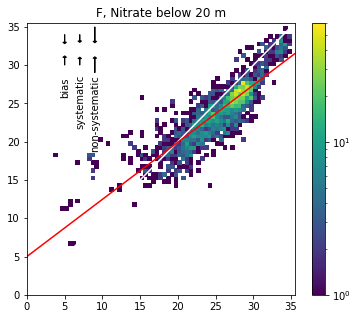

In [29]:
temp1 = read_pieces(pieces)
temp1['NO3'] = temp1.N.fillna(value=temp1.NO23).fillna(value=temp1['Nitrate_plus_Nitrite [umol/L]'])
modF = plot_and_stats(temp1, 'F', idepth, jdepth)
modF.style.format(myformat)

It makes it worse, but the maximum number of points (yellow patch) is not Puget Sound.

## Question 2: Is the bias improving or getting worse in time?

In [34]:
#temp1.set_index('dtUTC', inplace=True)
temp1.index = pd.to_datetime(temp1.index)

21.38997868353431 441.4661096800038


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
F15,392,-2.3,3.0,0.22,0.29,5.4,2.5,1.6,0.23


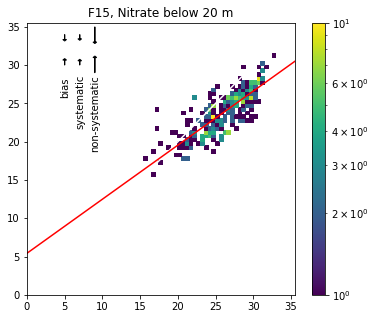

In [38]:
modF15 = plot_and_stats(temp1[temp1.index < dt.datetime(2016, 1, 1)], 'F15', idepth, jdepth)
modF15.style.format(myformat)

21.38997868353431 441.4661096800038


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
F16,1072,-1.7,2.5,0.096,0.16,2.7,1.8,1.7,0.14


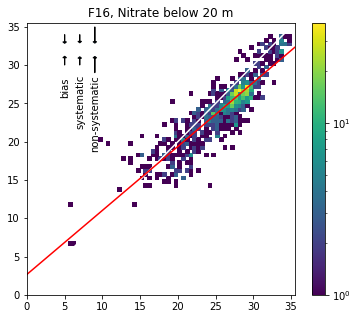

In [40]:
modF16 = plot_and_stats(temp1[(temp1.index >= dt.datetime(2016, 1, 1)) & (temp1.index < dt.datetime(2017, 1, 1))], 'F16', idepth, jdepth)
modF16.style.format(myformat)

21.38997868353431 441.4661096800038


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
F17,965,-1.2,2.7,0.1,0.31,6.7,1.9,1.9,0.36


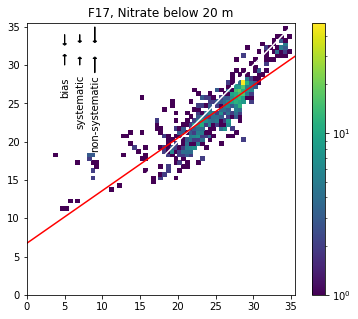

In [41]:
modF17 = plot_and_stats(temp1[temp1.index >= dt.datetime(2017, 1, 1)], 'F17', idepth, jdepth)
modF17.style.format(myformat)

Bias is improving in time.